## Continual learning on the MNIST permutation task


In [1]:
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.nn import functional as F
#from torch import nn
from torch import autograd

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor
    
from include import *

num GPUs 1


In [2]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

### Get training and test data loader for permuated MNIST

In [3]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        self.data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.data])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.data[sample_idx]]
    
###

def get_permute_mnist(num_tasks=5):
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_tasks):
        print(i)
        #train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
        #                                              batch_size=batch_size,
        #                                              num_workers=4)
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size)
        
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader

## Code to evaluate the EWC variants, and training on all the data

In [4]:
def train_model(model,train_gen,ewc,num_epochs=20):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD( model.parameters(), lr=lr)    
    for epoch in range(num_epochs):
        for i ,(images,labels) in enumerate(train_gen):
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
    
            optimizer.zero_grad()
            outputs = model(images)
            
            loss_function = nn.MSELoss()
            labels = torch.nn.functional.one_hot(labels).to(torch.float32)
            loss = loss_function(outputs, labels)
            #if i==0 and epoch==0:
            #    print("std:",loss.data)
            loss += ewc.loss(model)
            #if i==0 and epoch==0:
            #    print("ewc:",loss.data)
            loss.backward()
            optimizer.step()
    
            if i == 0: #and epoch == num_epochs - 1:
                print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))

# train over multiple data loaders, used to evaluate performance for training on all sets
def train_model_over_sets(model,train_gens,num_epochs=20,shuffle=True):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD( model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        
        if shuffle:
            perm = np.random.permutation(len(train_gens))
        else:
            perm = [i for i in range( len(train_gens) )]
        for j in perm:
            train_gen = train_gens[j]
            for i ,(images,labels) in enumerate(train_gen):
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
    
                optimizer.zero_grad()
                outputs = model(images)
                
                loss_function = nn.MSELoss()
                labels = torch.nn.functional.one_hot(labels).to(torch.float32)
                loss = loss_function(outputs, labels)
                
                loss.backward()
                optimizer.step()
    
                if i == 0:
                    print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))
                            
def test_model(model,test_gen):
    correct = 0
    total = 0
    for images,labels in test_gen:
        images = Variable(images).cuda()
        labels = labels.cuda()
  
        output = model(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
    #return ((100.0*correct)/(total+1))
    return ((100.0*correct)/(total))

In [5]:
def run_simulation(net,train_loader,test_loader,ewc,num_epochs=20):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    for k in range(num_tasks): 
        
        # train model
        train_model(net,train_loader[k],ewc,num_epochs=num_epochs)
        # compute Hessian before updating
        if ewc.lam>0 and k < num_tasks-1:
            #ewc.compute_data( net,train_loader[k] )
            ewc.update( net,train_loader[k] )

        inderrors = []
        for i in range(k+1):
            erri = test_model(net,test_loader[i])
            inderrors += [erri]
            res[k] += erri / (k+1)
        print("test performance : ", res)
        print("individual errors: ", inderrors)
    return res

def train_on_all(net,train_loader,test_loader,num_epochs=20):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    for k in range(num_tasks): 
        train_model_over_sets(net,[train_loader[j] for j in range(k+1)],num_epochs=20)
        for i in range(k+1):
            res[k] += test_model(net,test_loader[i]) / (k+1)
    return res

# Random feature model

In [6]:
class Net(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
  
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def get_random_feature_model(input_size = 784,hidden_size = 6*784,num_classes = 10):
    net = Net(input_size, hidden_size, num_classes).cuda()
    for param in net.fc1.parameters():
        param.requires_grad = False
    return net

In [7]:
num_tasks = 10
#num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 80 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-4 # size of step

In [8]:
train_loader, test_loader = get_permute_mnist(num_tasks)

0
1
2
3
4
5
6
7
8
9


In [9]:
respp = run_simulation( get_random_feature_model() ,train_loader,test_loader,EWCplusplus(lam=1.5e-3,s=100),num_epochs=num_epochs )

EWC++  100 0.0015
Epoch [1/80], Loss: 0.1014
Epoch [2/80], Loss: 0.0255
Epoch [3/80], Loss: 0.0201
Epoch [4/80], Loss: 0.0178
Epoch [5/80], Loss: 0.0165
Epoch [6/80], Loss: 0.0157
Epoch [7/80], Loss: 0.0151
Epoch [8/80], Loss: 0.0146
Epoch [9/80], Loss: 0.0143
Epoch [10/80], Loss: 0.0140
Epoch [11/80], Loss: 0.0137
Epoch [12/80], Loss: 0.0135
Epoch [13/80], Loss: 0.0133
Epoch [14/80], Loss: 0.0131
Epoch [15/80], Loss: 0.0129
Epoch [16/80], Loss: 0.0128
Epoch [17/80], Loss: 0.0127
Epoch [18/80], Loss: 0.0125
Epoch [19/80], Loss: 0.0124
Epoch [20/80], Loss: 0.0123
Epoch [21/80], Loss: 0.0122
Epoch [22/80], Loss: 0.0122
Epoch [23/80], Loss: 0.0121
Epoch [24/80], Loss: 0.0120
Epoch [25/80], Loss: 0.0119
Epoch [26/80], Loss: 0.0119
Epoch [27/80], Loss: 0.0118
Epoch [28/80], Loss: 0.0118
Epoch [29/80], Loss: 0.0117
Epoch [30/80], Loss: 0.0117
Epoch [31/80], Loss: 0.0116
Epoch [32/80], Loss: 0.0116
Epoch [33/80], Loss: 0.0115
Epoch [34/80], Loss: 0.0115
Epoch [35/80], Loss: 0.0115
Epoch [36/8

Epoch [21/80], Loss: 0.0411
Epoch [22/80], Loss: 0.0398
Epoch [23/80], Loss: 0.0400
Epoch [24/80], Loss: 0.0389
Epoch [25/80], Loss: 0.0405
Epoch [26/80], Loss: 0.0433
Epoch [27/80], Loss: 0.0484
Epoch [28/80], Loss: 0.0396
Epoch [29/80], Loss: 0.0453
Epoch [30/80], Loss: 0.0428
Epoch [31/80], Loss: 0.0377
Epoch [32/80], Loss: 0.0376
Epoch [33/80], Loss: 0.0360
Epoch [34/80], Loss: 0.0444
Epoch [35/80], Loss: 0.0353
Epoch [36/80], Loss: 0.0375
Epoch [37/80], Loss: 0.0350
Epoch [38/80], Loss: 0.0349
Epoch [39/80], Loss: 0.0343
Epoch [40/80], Loss: 0.0348
Epoch [41/80], Loss: 0.0339
Epoch [42/80], Loss: 0.0353
Epoch [43/80], Loss: 0.0337
Epoch [44/80], Loss: 0.0396
Epoch [45/80], Loss: 0.0335
Epoch [46/80], Loss: 0.0332
Epoch [47/80], Loss: 0.0349
Epoch [48/80], Loss: 0.0365
Epoch [49/80], Loss: 0.0328
Epoch [50/80], Loss: 0.0348
Epoch [51/80], Loss: 0.0363
Epoch [52/80], Loss: 0.0318
Epoch [53/80], Loss: 0.0317
Epoch [54/80], Loss: 0.0351
Epoch [55/80], Loss: 0.0454
Epoch [56/80], Loss:

Epoch [27/80], Loss: 0.0437
Epoch [28/80], Loss: 0.0435
Epoch [29/80], Loss: 0.0437
Epoch [30/80], Loss: 0.0812
Epoch [31/80], Loss: 0.0433
Epoch [32/80], Loss: 0.0802
Epoch [33/80], Loss: 0.0608
Epoch [34/80], Loss: 0.0444
Epoch [35/80], Loss: 0.0428
Epoch [36/80], Loss: 0.0412
Epoch [37/80], Loss: 0.0578
Epoch [38/80], Loss: 0.0409
Epoch [39/80], Loss: 0.0474
Epoch [40/80], Loss: 0.0424
Epoch [41/80], Loss: 0.0409
Epoch [42/80], Loss: 0.0400
Epoch [43/80], Loss: 0.0397
Epoch [44/80], Loss: 0.0405
Epoch [45/80], Loss: 0.0557
Epoch [46/80], Loss: 0.0409
Epoch [47/80], Loss: 0.0431
Epoch [48/80], Loss: 0.0385
Epoch [49/80], Loss: 0.0527
Epoch [50/80], Loss: 0.0383
Epoch [51/80], Loss: 0.0382
Epoch [52/80], Loss: 0.0376
Epoch [53/80], Loss: 0.1059
Epoch [54/80], Loss: 0.0476
Epoch [55/80], Loss: 0.0371
Epoch [56/80], Loss: 0.0378
Epoch [57/80], Loss: 0.0368
Epoch [58/80], Loss: 0.0368
Epoch [59/80], Loss: 0.0456
Epoch [60/80], Loss: 0.0372
Epoch [61/80], Loss: 0.0368
Epoch [62/80], Loss:

Epoch [22/80], Loss: 0.0546
Epoch [23/80], Loss: 0.0508
Epoch [24/80], Loss: 0.0501
Epoch [25/80], Loss: 0.0635
Epoch [26/80], Loss: 0.0496
Epoch [27/80], Loss: 0.0492
Epoch [28/80], Loss: 0.0599
Epoch [29/80], Loss: 0.0510
Epoch [30/80], Loss: 0.0555
Epoch [31/80], Loss: 0.0688
Epoch [32/80], Loss: 0.0488
Epoch [33/80], Loss: 0.0556
Epoch [34/80], Loss: 0.0547
Epoch [35/80], Loss: 0.0471
Epoch [36/80], Loss: 0.0595
Epoch [37/80], Loss: 0.0476
Epoch [38/80], Loss: 0.0557
Epoch [39/80], Loss: 0.0803
Epoch [40/80], Loss: 0.0563
Epoch [41/80], Loss: 0.0453
Epoch [42/80], Loss: 0.0483
Epoch [43/80], Loss: 0.0445
Epoch [44/80], Loss: 0.0523
Epoch [45/80], Loss: 0.0450
Epoch [46/80], Loss: 0.0430
Epoch [47/80], Loss: 0.0428
Epoch [48/80], Loss: 0.0531
Epoch [49/80], Loss: 0.0452
Epoch [50/80], Loss: 0.0425
Epoch [51/80], Loss: 0.0571
Epoch [52/80], Loss: 0.0442
Epoch [53/80], Loss: 0.0425
Epoch [54/80], Loss: 0.0422
Epoch [55/80], Loss: 0.0423
Epoch [56/80], Loss: 0.0429
Epoch [57/80], Loss:

In [10]:
resppbig = run_simulation( get_random_feature_model() ,train_loader,test_loader,EWCplusplus(lam=1.5e-3,s=400),num_epochs=num_epochs )

EWC++  400 0.0015
Epoch [1/80], Loss: 0.1140
Epoch [2/80], Loss: 0.0257
Epoch [3/80], Loss: 0.0203
Epoch [4/80], Loss: 0.0179
Epoch [5/80], Loss: 0.0167
Epoch [6/80], Loss: 0.0158
Epoch [7/80], Loss: 0.0153
Epoch [8/80], Loss: 0.0148
Epoch [9/80], Loss: 0.0145
Epoch [10/80], Loss: 0.0142
Epoch [11/80], Loss: 0.0139
Epoch [12/80], Loss: 0.0137
Epoch [13/80], Loss: 0.0135
Epoch [14/80], Loss: 0.0134
Epoch [15/80], Loss: 0.0132
Epoch [16/80], Loss: 0.0131
Epoch [17/80], Loss: 0.0130
Epoch [18/80], Loss: 0.0128
Epoch [19/80], Loss: 0.0127
Epoch [20/80], Loss: 0.0126
Epoch [21/80], Loss: 0.0126
Epoch [22/80], Loss: 0.0125
Epoch [23/80], Loss: 0.0124
Epoch [24/80], Loss: 0.0124
Epoch [25/80], Loss: 0.0123
Epoch [26/80], Loss: 0.0122
Epoch [27/80], Loss: 0.0122
Epoch [28/80], Loss: 0.0121
Epoch [29/80], Loss: 0.0121
Epoch [30/80], Loss: 0.0120
Epoch [31/80], Loss: 0.0120
Epoch [32/80], Loss: 0.0120
Epoch [33/80], Loss: 0.0119
Epoch [34/80], Loss: 0.0119
Epoch [35/80], Loss: 0.0118
Epoch [36/8

Epoch [18/80], Loss: 0.0641
Epoch [19/80], Loss: 0.0510
Epoch [20/80], Loss: 0.0430
Epoch [21/80], Loss: 0.0421
Epoch [22/80], Loss: 0.0418
Epoch [23/80], Loss: 0.0414
Epoch [24/80], Loss: 0.0410
Epoch [25/80], Loss: 0.0416
Epoch [26/80], Loss: 0.0397
Epoch [27/80], Loss: 0.0453
Epoch [28/80], Loss: 0.0389
Epoch [29/80], Loss: 0.0387
Epoch [30/80], Loss: 0.0484
Epoch [31/80], Loss: 0.0389
Epoch [32/80], Loss: 0.0375
Epoch [33/80], Loss: 0.0372
Epoch [34/80], Loss: 0.0399
Epoch [35/80], Loss: 0.0428
Epoch [36/80], Loss: 0.0379
Epoch [37/80], Loss: 0.0420
Epoch [38/80], Loss: 0.0360
Epoch [39/80], Loss: 0.0357
Epoch [40/80], Loss: 0.0369
Epoch [41/80], Loss: 0.0379
Epoch [42/80], Loss: 0.0343
Epoch [43/80], Loss: 0.0346
Epoch [44/80], Loss: 0.0360
Epoch [45/80], Loss: 0.0343
Epoch [46/80], Loss: 0.0340
Epoch [47/80], Loss: 0.0339
Epoch [48/80], Loss: 0.0333
Epoch [49/80], Loss: 0.0339
Epoch [50/80], Loss: 0.0719
Epoch [51/80], Loss: 0.0323
Epoch [52/80], Loss: 0.0322
Epoch [53/80], Loss:

Epoch [25/80], Loss: 0.0616
Epoch [26/80], Loss: 0.0463
Epoch [27/80], Loss: 0.0485
Epoch [28/80], Loss: 0.0450
Epoch [29/80], Loss: 0.0454
Epoch [30/80], Loss: 0.0447
Epoch [31/80], Loss: 0.0449
Epoch [32/80], Loss: 0.0471
Epoch [33/80], Loss: 0.0440
Epoch [34/80], Loss: 0.0428
Epoch [35/80], Loss: 0.0426
Epoch [36/80], Loss: 0.0442
Epoch [37/80], Loss: 0.0420
Epoch [38/80], Loss: 0.0586
Epoch [39/80], Loss: 0.0520
Epoch [40/80], Loss: 0.0428
Epoch [41/80], Loss: 0.0443
Epoch [42/80], Loss: 0.0423
Epoch [43/80], Loss: 0.0498
Epoch [44/80], Loss: 0.0410
Epoch [45/80], Loss: 0.0454
Epoch [46/80], Loss: 0.0458
Epoch [47/80], Loss: 0.0516
Epoch [48/80], Loss: 0.0408
Epoch [49/80], Loss: 0.0396
Epoch [50/80], Loss: 0.0445
Epoch [51/80], Loss: 0.0447
Epoch [52/80], Loss: 0.0395
Epoch [53/80], Loss: 0.0414
Epoch [54/80], Loss: 0.0537
Epoch [55/80], Loss: 0.0412
Epoch [56/80], Loss: 0.0432
Epoch [57/80], Loss: 0.0435
Epoch [58/80], Loss: 0.0378
Epoch [59/80], Loss: 0.0777
Epoch [60/80], Loss:

Epoch [39/80], Loss: 0.0490
Epoch [40/80], Loss: 0.0462
Epoch [41/80], Loss: 0.1208
Epoch [42/80], Loss: 0.0456
Epoch [43/80], Loss: 0.0515
Epoch [44/80], Loss: 0.0451
Epoch [45/80], Loss: 0.0462
Epoch [46/80], Loss: 0.0456
Epoch [47/80], Loss: 0.0829
Epoch [48/80], Loss: 0.0610
Epoch [49/80], Loss: 0.0440
Epoch [50/80], Loss: 0.0438
Epoch [51/80], Loss: 0.0453
Epoch [52/80], Loss: 0.0457
Epoch [53/80], Loss: 0.0432
Epoch [54/80], Loss: 0.0438
Epoch [55/80], Loss: 0.0447
Epoch [56/80], Loss: 0.0433
Epoch [57/80], Loss: 0.0426
Epoch [58/80], Loss: 0.0422
Epoch [59/80], Loss: 0.0579
Epoch [60/80], Loss: 0.0457
Epoch [61/80], Loss: 0.0433
Epoch [62/80], Loss: 0.0453
Epoch [63/80], Loss: 0.0442
Epoch [64/80], Loss: 0.0764
Epoch [65/80], Loss: 0.0422
Epoch [66/80], Loss: 0.0569
Epoch [67/80], Loss: 0.0409
Epoch [68/80], Loss: 0.0565
Epoch [69/80], Loss: 0.0408
Epoch [70/80], Loss: 0.0429
Epoch [71/80], Loss: 0.0575
Epoch [72/80], Loss: 0.0691
Epoch [73/80], Loss: 0.0529
Epoch [74/80], Loss:

In [11]:
#resppvery = run_simulation( get_random_feature_model() ,train_loader,test_loader,EWCplusplus(lam=1.5e-3,s=800),num_epochs=num_epochs )

In [12]:
resall = train_on_all( get_random_feature_model() ,train_loader,test_loader,num_epochs=num_epochs)

Epoch [1/20], Loss: 0.1130
Epoch [2/20], Loss: 0.0257
Epoch [3/20], Loss: 0.0204
Epoch [4/20], Loss: 0.0182
Epoch [5/20], Loss: 0.0169
Epoch [6/20], Loss: 0.0161
Epoch [7/20], Loss: 0.0155
Epoch [8/20], Loss: 0.0151
Epoch [9/20], Loss: 0.0147
Epoch [10/20], Loss: 0.0144
Epoch [11/20], Loss: 0.0141
Epoch [12/20], Loss: 0.0138
Epoch [13/20], Loss: 0.0136
Epoch [14/20], Loss: 0.0134
Epoch [15/20], Loss: 0.0133
Epoch [16/20], Loss: 0.0131
Epoch [17/20], Loss: 0.0130
Epoch [18/20], Loss: 0.0129
Epoch [19/20], Loss: 0.0127
Epoch [20/20], Loss: 0.0126
Epoch [1/20], Loss: 0.0125
Epoch [1/20], Loss: 0.1403
Epoch [2/20], Loss: 0.0285
Epoch [2/20], Loss: 0.0289
Epoch [3/20], Loss: 0.0134
Epoch [3/20], Loss: 0.0349
Epoch [4/20], Loss: 0.0210
Epoch [4/20], Loss: 0.0209
Epoch [5/20], Loss: 0.0137
Epoch [5/20], Loss: 0.0270
Epoch [6/20], Loss: 0.0180
Epoch [6/20], Loss: 0.0228
Epoch [7/20], Loss: 0.0171
Epoch [7/20], Loss: 0.0213
Epoch [8/20], Loss: 0.0173
Epoch [8/20], Loss: 0.0178
Epoch [9/20], Los

Epoch [20/20], Loss: 0.0282
Epoch [20/20], Loss: 0.0350
Epoch [1/20], Loss: 0.0195
Epoch [1/20], Loss: 0.0255
Epoch [1/20], Loss: 0.0312
Epoch [1/20], Loss: 0.1160
Epoch [1/20], Loss: 0.0355
Epoch [1/20], Loss: 0.0357
Epoch [2/20], Loss: 0.0265
Epoch [2/20], Loss: 0.0219
Epoch [2/20], Loss: 0.0407
Epoch [2/20], Loss: 0.0260
Epoch [2/20], Loss: 0.0539
Epoch [2/20], Loss: 0.0399
Epoch [3/20], Loss: 0.0249
Epoch [3/20], Loss: 0.0308
Epoch [3/20], Loss: 0.0240
Epoch [3/20], Loss: 0.0310
Epoch [3/20], Loss: 0.0395
Epoch [3/20], Loss: 0.0455
Epoch [4/20], Loss: 0.0294
Epoch [4/20], Loss: 0.0274
Epoch [4/20], Loss: 0.0290
Epoch [4/20], Loss: 0.0355
Epoch [4/20], Loss: 0.0295
Epoch [4/20], Loss: 0.0361
Epoch [5/20], Loss: 0.0191
Epoch [5/20], Loss: 0.0354
Epoch [5/20], Loss: 0.0321
Epoch [5/20], Loss: 0.0298
Epoch [5/20], Loss: 0.0355
Epoch [5/20], Loss: 0.0334
Epoch [6/20], Loss: 0.0239
Epoch [6/20], Loss: 0.0216
Epoch [6/20], Loss: 0.0310
Epoch [6/20], Loss: 0.0363
Epoch [6/20], Loss: 0.0307

Epoch [5/20], Loss: 0.0388
Epoch [5/20], Loss: 0.0408
Epoch [5/20], Loss: 0.0458
Epoch [6/20], Loss: 0.0236
Epoch [6/20], Loss: 0.0276
Epoch [6/20], Loss: 0.0452
Epoch [6/20], Loss: 0.0371
Epoch [6/20], Loss: 0.0305
Epoch [6/20], Loss: 0.0410
Epoch [6/20], Loss: 0.0437
Epoch [6/20], Loss: 0.0511
Epoch [7/20], Loss: 0.0276
Epoch [7/20], Loss: 0.0252
Epoch [7/20], Loss: 0.0308
Epoch [7/20], Loss: 0.0379
Epoch [7/20], Loss: 0.0342
Epoch [7/20], Loss: 0.0407
Epoch [7/20], Loss: 0.0503
Epoch [7/20], Loss: 0.0450
Epoch [8/20], Loss: 0.0398
Epoch [8/20], Loss: 0.0301
Epoch [8/20], Loss: 0.0335
Epoch [8/20], Loss: 0.0267
Epoch [8/20], Loss: 0.0437
Epoch [8/20], Loss: 0.0425
Epoch [8/20], Loss: 0.0356
Epoch [8/20], Loss: 0.0416
Epoch [9/20], Loss: 0.0232
Epoch [9/20], Loss: 0.0323
Epoch [9/20], Loss: 0.0338
Epoch [9/20], Loss: 0.0486
Epoch [9/20], Loss: 0.0386
Epoch [9/20], Loss: 0.0486
Epoch [9/20], Loss: 0.0484
Epoch [9/20], Loss: 0.0390
Epoch [10/20], Loss: 0.0227
Epoch [10/20], Loss: 0.0290

Epoch [20/20], Loss: 0.0323
Epoch [20/20], Loss: 0.0435
Epoch [20/20], Loss: 0.0367
Epoch [20/20], Loss: 0.0422
Epoch [20/20], Loss: 0.0465
Epoch [20/20], Loss: 0.0492
Epoch [1/20], Loss: 0.0219
Epoch [1/20], Loss: 0.0382
Epoch [1/20], Loss: 0.0319
Epoch [1/20], Loss: 0.0460
Epoch [1/20], Loss: 0.0390
Epoch [1/20], Loss: 0.0447
Epoch [1/20], Loss: 0.0471
Epoch [1/20], Loss: 0.0573
Epoch [1/20], Loss: 0.1237
Epoch [1/20], Loss: 0.0664
Epoch [2/20], Loss: 0.0335
Epoch [2/20], Loss: 0.0397
Epoch [2/20], Loss: 0.0497
Epoch [2/20], Loss: 0.0468
Epoch [2/20], Loss: 0.0417
Epoch [2/20], Loss: 0.0449
Epoch [2/20], Loss: 0.0493
Epoch [2/20], Loss: 0.0486
Epoch [2/20], Loss: 0.0531
Epoch [2/20], Loss: 0.0500
Epoch [3/20], Loss: 0.0228
Epoch [3/20], Loss: 0.0557
Epoch [3/20], Loss: 0.0318
Epoch [3/20], Loss: 0.0334
Epoch [3/20], Loss: 0.0406
Epoch [3/20], Loss: 0.0562
Epoch [3/20], Loss: 0.0514
Epoch [3/20], Loss: 0.0471
Epoch [3/20], Loss: 0.0566
Epoch [3/20], Loss: 0.0615
Epoch [4/20], Loss: 0.

In [13]:
lam = 5e-6
resewc = run_simulation( get_random_feature_model(),train_loader,test_loader,EWC(lam=lam),num_epochs=num_epochs )

EWC 5e-06
Epoch [1/80], Loss: 0.1034
Epoch [2/80], Loss: 0.0257
Epoch [3/80], Loss: 0.0206
Epoch [4/80], Loss: 0.0183
Epoch [5/80], Loss: 0.0171
Epoch [6/80], Loss: 0.0162
Epoch [7/80], Loss: 0.0156
Epoch [8/80], Loss: 0.0151
Epoch [9/80], Loss: 0.0147
Epoch [10/80], Loss: 0.0144
Epoch [11/80], Loss: 0.0141
Epoch [12/80], Loss: 0.0139
Epoch [13/80], Loss: 0.0136
Epoch [14/80], Loss: 0.0134
Epoch [15/80], Loss: 0.0133
Epoch [16/80], Loss: 0.0131
Epoch [17/80], Loss: 0.0130
Epoch [18/80], Loss: 0.0129
Epoch [19/80], Loss: 0.0127
Epoch [20/80], Loss: 0.0126
Epoch [21/80], Loss: 0.0126
Epoch [22/80], Loss: 0.0125
Epoch [23/80], Loss: 0.0124
Epoch [24/80], Loss: 0.0123
Epoch [25/80], Loss: 0.0123
Epoch [26/80], Loss: 0.0122
Epoch [27/80], Loss: 0.0121
Epoch [28/80], Loss: 0.0121
Epoch [29/80], Loss: 0.0120
Epoch [30/80], Loss: 0.0120
Epoch [31/80], Loss: 0.0119
Epoch [32/80], Loss: 0.0119
Epoch [33/80], Loss: 0.0119
Epoch [34/80], Loss: 0.0118
Epoch [35/80], Loss: 0.0118
Epoch [36/80], Loss

Epoch [19/80], Loss: 0.0493
Epoch [20/80], Loss: 0.0493
Epoch [21/80], Loss: 0.0493
Epoch [22/80], Loss: 0.0493
Epoch [23/80], Loss: 0.0493
Epoch [24/80], Loss: 0.0493
Epoch [25/80], Loss: 0.0493
Epoch [26/80], Loss: 0.0493
Epoch [27/80], Loss: 0.0493
Epoch [28/80], Loss: 0.0493
Epoch [29/80], Loss: 0.0493
Epoch [30/80], Loss: 0.0493
Epoch [31/80], Loss: 0.0493
Epoch [32/80], Loss: 0.0493
Epoch [33/80], Loss: 0.0493
Epoch [34/80], Loss: 0.0493
Epoch [35/80], Loss: 0.0493
Epoch [36/80], Loss: 0.0493
Epoch [37/80], Loss: 0.0493
Epoch [38/80], Loss: 0.0493
Epoch [39/80], Loss: 0.0493
Epoch [40/80], Loss: 0.0493
Epoch [41/80], Loss: 0.0493
Epoch [42/80], Loss: 0.0493
Epoch [43/80], Loss: 0.0493
Epoch [44/80], Loss: 0.0493
Epoch [45/80], Loss: 0.0493
Epoch [46/80], Loss: 0.0493
Epoch [47/80], Loss: 0.0493
Epoch [48/80], Loss: 0.0493
Epoch [49/80], Loss: 0.0493
Epoch [50/80], Loss: 0.0493
Epoch [51/80], Loss: 0.0493
Epoch [52/80], Loss: 0.0493
Epoch [53/80], Loss: 0.0493
Epoch [54/80], Loss:

Epoch [26/80], Loss: 0.0610
Epoch [27/80], Loss: 0.0610
Epoch [28/80], Loss: 0.0610
Epoch [29/80], Loss: 0.0610
Epoch [30/80], Loss: 0.0610
Epoch [31/80], Loss: 0.0610
Epoch [32/80], Loss: 0.0610
Epoch [33/80], Loss: 0.0610
Epoch [34/80], Loss: 0.0610
Epoch [35/80], Loss: 0.0610
Epoch [36/80], Loss: 0.0610
Epoch [37/80], Loss: 0.0610
Epoch [38/80], Loss: 0.0610
Epoch [39/80], Loss: 0.0610
Epoch [40/80], Loss: 0.0610
Epoch [41/80], Loss: 0.0610
Epoch [42/80], Loss: 0.0610
Epoch [43/80], Loss: 0.0610
Epoch [44/80], Loss: 0.0610
Epoch [45/80], Loss: 0.0610
Epoch [46/80], Loss: 0.0610
Epoch [47/80], Loss: 0.0610
Epoch [48/80], Loss: 0.0610
Epoch [49/80], Loss: 0.0610
Epoch [50/80], Loss: 0.0610
Epoch [51/80], Loss: 0.0610
Epoch [52/80], Loss: 0.0610
Epoch [53/80], Loss: 0.0610
Epoch [54/80], Loss: 0.0610
Epoch [55/80], Loss: 0.0610
Epoch [56/80], Loss: 0.0610
Epoch [57/80], Loss: 0.0610
Epoch [58/80], Loss: 0.0610
Epoch [59/80], Loss: 0.0610
Epoch [60/80], Loss: 0.0610
Epoch [61/80], Loss:

Epoch [21/80], Loss: 0.0659
Epoch [22/80], Loss: 0.0659
Epoch [23/80], Loss: 0.0659
Epoch [24/80], Loss: 0.0659
Epoch [25/80], Loss: 0.0659
Epoch [26/80], Loss: 0.0659
Epoch [27/80], Loss: 0.0659
Epoch [28/80], Loss: 0.0659
Epoch [29/80], Loss: 0.0659
Epoch [30/80], Loss: 0.0659
Epoch [31/80], Loss: 0.0659
Epoch [32/80], Loss: 0.0659
Epoch [33/80], Loss: 0.0659
Epoch [34/80], Loss: 0.0659
Epoch [35/80], Loss: 0.0659
Epoch [36/80], Loss: 0.0659
Epoch [37/80], Loss: 0.0659
Epoch [38/80], Loss: 0.0659
Epoch [39/80], Loss: 0.0659
Epoch [40/80], Loss: 0.0659
Epoch [41/80], Loss: 0.0659
Epoch [42/80], Loss: 0.0659
Epoch [43/80], Loss: 0.0659
Epoch [44/80], Loss: 0.0659
Epoch [45/80], Loss: 0.0659
Epoch [46/80], Loss: 0.0659
Epoch [47/80], Loss: 0.0659
Epoch [48/80], Loss: 0.0659
Epoch [49/80], Loss: 0.0659
Epoch [50/80], Loss: 0.0659
Epoch [51/80], Loss: 0.0659
Epoch [52/80], Loss: 0.0659
Epoch [53/80], Loss: 0.0659
Epoch [54/80], Loss: 0.0659
Epoch [55/80], Loss: 0.0659
Epoch [56/80], Loss:

L2 5e-06
Epoch [1/80], Loss: 0.1068
Epoch [2/80], Loss: 0.0253
Epoch [3/80], Loss: 0.0202
Epoch [4/80], Loss: 0.0179
Epoch [5/80], Loss: 0.0167
Epoch [6/80], Loss: 0.0159
Epoch [7/80], Loss: 0.0154
Epoch [8/80], Loss: 0.0149
Epoch [9/80], Loss: 0.0146
Epoch [10/80], Loss: 0.0143
Epoch [11/80], Loss: 0.0140
Epoch [12/80], Loss: 0.0138
Epoch [13/80], Loss: 0.0136
Epoch [14/80], Loss: 0.0135
Epoch [15/80], Loss: 0.0133
Epoch [16/80], Loss: 0.0132
Epoch [17/80], Loss: 0.0131
Epoch [18/80], Loss: 0.0130
Epoch [19/80], Loss: 0.0129
Epoch [20/80], Loss: 0.0128
Epoch [21/80], Loss: 0.0127
Epoch [22/80], Loss: 0.0126
Epoch [23/80], Loss: 0.0126
Epoch [24/80], Loss: 0.0125
Epoch [25/80], Loss: 0.0124
Epoch [26/80], Loss: 0.0124
Epoch [27/80], Loss: 0.0123
Epoch [28/80], Loss: 0.0123
Epoch [29/80], Loss: 0.0123
Epoch [30/80], Loss: 0.0122
Epoch [31/80], Loss: 0.0122
Epoch [32/80], Loss: 0.0122
Epoch [33/80], Loss: 0.0121
Epoch [34/80], Loss: 0.0121
Epoch [35/80], Loss: 0.0121
Epoch [36/80], Loss:

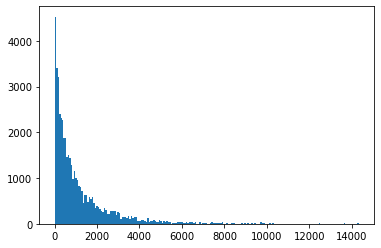

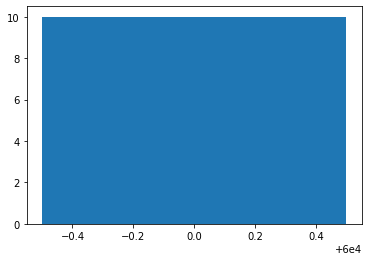

task data norm and number entries: tensor(309806.8750, device='cuda:0') torch.Size([47050])
test performance :  [96.93999481  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
individual errors:  [tensor(96.9400, device='cuda:0')]
Epoch [1/80], Loss: 0.1653
Epoch [2/80], Loss: 0.0513
Epoch [3/80], Loss: 0.0506
Epoch [4/80], Loss: 0.0505
Epoch [5/80], Loss: 0.0505
Epoch [6/80], Loss: 0.0505
Epoch [7/80], Loss: 0.0505
Epoch [8/80], Loss: 0.0505
Epoch [9/80], Loss: 0.0505
Epoch [10/80], Loss: 0.0505
Epoch [11/80], Loss: 0.0505
Epoch [12/80], Loss: 0.0505
Epoch [13/80], Loss: 0.0505
Epoch [14/80], Loss: 0.0505
Epoch [15/80], Loss: 0.0505
Epoch [16/80], Loss: 0.0505
Epoch [17/80], Loss: 0.0505
Epoch [18/80], Loss: 0.0505
Epoch [19/80], Loss: 0.0505
Epoch [20/80], Loss: 0.0505
Epoch [21/80], Loss: 0.0505
Epoch [22/80], Loss: 0.0505
Epoch [23/80], Loss: 0.0505
Epoch [24/80], Loss: 0.0505
Epoch [25/80], Loss: 0.0505
Epoch [26/80], Loss: 0.0505

Epoch [18/80], Loss: 0.0599
Epoch [19/80], Loss: 0.0599
Epoch [20/80], Loss: 0.0599
Epoch [21/80], Loss: 0.0599
Epoch [22/80], Loss: 0.0599
Epoch [23/80], Loss: 0.0599
Epoch [24/80], Loss: 0.0599
Epoch [25/80], Loss: 0.0599
Epoch [26/80], Loss: 0.0599
Epoch [27/80], Loss: 0.0599
Epoch [28/80], Loss: 0.0599
Epoch [29/80], Loss: 0.0599
Epoch [30/80], Loss: 0.0599
Epoch [31/80], Loss: 0.0599
Epoch [32/80], Loss: 0.0599
Epoch [33/80], Loss: 0.0599
Epoch [34/80], Loss: 0.0599
Epoch [35/80], Loss: 0.0599
Epoch [36/80], Loss: 0.0599
Epoch [37/80], Loss: 0.0599
Epoch [38/80], Loss: 0.0599
Epoch [39/80], Loss: 0.0599
Epoch [40/80], Loss: 0.0599
Epoch [41/80], Loss: 0.0599
Epoch [42/80], Loss: 0.0599
Epoch [43/80], Loss: 0.0599
Epoch [44/80], Loss: 0.0599
Epoch [45/80], Loss: 0.0599
Epoch [46/80], Loss: 0.0599
Epoch [47/80], Loss: 0.0599
Epoch [48/80], Loss: 0.0599
Epoch [49/80], Loss: 0.0599
Epoch [50/80], Loss: 0.0599
Epoch [51/80], Loss: 0.0599
Epoch [52/80], Loss: 0.0599
Epoch [53/80], Loss:

Epoch [33/80], Loss: 0.0751
Epoch [34/80], Loss: 0.0751
Epoch [35/80], Loss: 0.0751
Epoch [36/80], Loss: 0.0751
Epoch [37/80], Loss: 0.0751
Epoch [38/80], Loss: 0.0751
Epoch [39/80], Loss: 0.0751
Epoch [40/80], Loss: 0.0751
Epoch [41/80], Loss: 0.0751
Epoch [42/80], Loss: 0.0751
Epoch [43/80], Loss: 0.0751
Epoch [44/80], Loss: 0.0751
Epoch [45/80], Loss: 0.0751
Epoch [46/80], Loss: 0.0751
Epoch [47/80], Loss: 0.0751
Epoch [48/80], Loss: 0.0751
Epoch [49/80], Loss: 0.0751
Epoch [50/80], Loss: 0.0751
Epoch [51/80], Loss: 0.0751
Epoch [52/80], Loss: 0.0751
Epoch [53/80], Loss: 0.0751
Epoch [54/80], Loss: 0.0751
Epoch [55/80], Loss: 0.0751
Epoch [56/80], Loss: 0.0751
Epoch [57/80], Loss: 0.0751
Epoch [58/80], Loss: 0.0751
Epoch [59/80], Loss: 0.0751
Epoch [60/80], Loss: 0.0751
Epoch [61/80], Loss: 0.0751
Epoch [62/80], Loss: 0.0751
Epoch [63/80], Loss: 0.0751
Epoch [64/80], Loss: 0.0751
Epoch [65/80], Loss: 0.0751
Epoch [66/80], Loss: 0.0751
Epoch [67/80], Loss: 0.0751
Epoch [68/80], Loss:

In [14]:
lam = 5e-6
l2new = run_simulation( get_random_feature_model() ,train_loader,test_loader,L2(lam=lam),num_epochs=num_epochs )

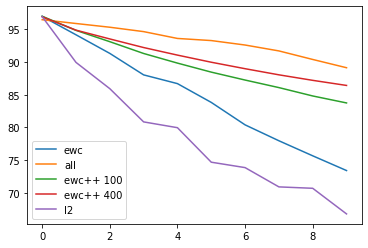

In [16]:
plt.plot(resewc,label='ewc')
plt.plot(resall,label='all')
plt.plot(respp,label='ewc++ 100')
plt.plot(resppbig,label='ewc++ 400')
#plt.plot(resppvery,label='ewc++ 800')
plt.plot(l2new,label='l2')

plt.legend()
plt.show()

In [17]:
results = [resewc,resall,respp,resppbig,l2new]

def res_to_mtx(losses,filename):
    ks = [i for i in range(len(losses[0]))]
    A = [np.array(ks)]
    A += losses
    A = np.vstack( A ).T
    print(A.shape)
    np.savetxt(filename, A, delimiter=' ')

res_to_mtx(results,"MNIST_permutation_rand_feat.dat")

(10, 6)
